**PyTorch workflow**

In [288]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [289]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Data preparing and loading

In [290]:
#Create known parameters
weight = 0.7
bias = 0.3

#Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end , step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [291]:
len(X), len(y)

(50, 50)

Splitting data into training and test sets


In [292]:
#Create a train-test split
train_split = int(0.8 * len(X))
train_split

40

In [293]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [294]:
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Visualizing the data

In [295]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data, and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue after converting to NumPy
    plt.scatter(train_data.cpu().numpy(), 
                train_labels.cpu().numpy(), 
                c="b", 
                s=4, 
                label="Training data")

    # Plot testing data in green after converting to NumPy
    plt.scatter(test_data.cpu().numpy(), 
                test_labels.cpu().numpy(), 
                c="g", 
                s=4, 
                label="Testing data")

    # Check if there are predictions to plot
    if predictions is not None:
        # Plot the predictions in red (this line was already correct)
        plt.scatter(test_data.cpu().numpy(), 
                    predictions.cpu().detach().squeeze().numpy(), 
                    c="r", 
                    s=4, 
                    label="Predictions")

    # Show the legend with descriptive labels
    plt.legend(prop={"size": 14})
    plt.title("Model Results")
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.show()

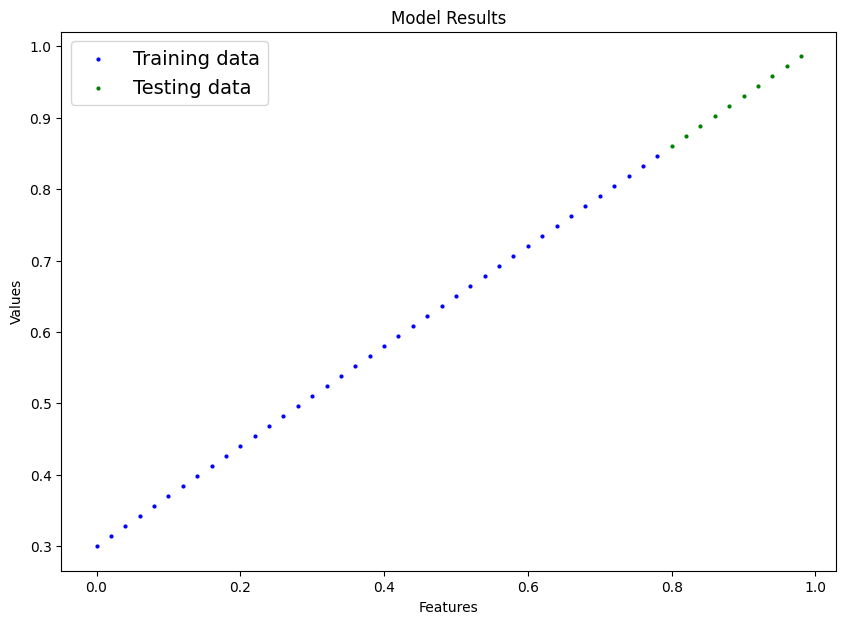

In [296]:
plot_predictions()

Build model

In [297]:
#Create a linear regression model class
class LinearRegressionModel(nn.Module): #almost everything in pytorch inherits nn.Module
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

In [298]:
#Checking the contents of our pytorch model
torch.manual_seed(123) #Create a random seed
model_0 = LinearRegressionModel() #Create an instance of the model
list(model_0.parameters()) #Looking at the parameters


[Parameter containing:
 tensor([-0.1115], requires_grad=True),
 Parameter containing:
 tensor([0.1204], requires_grad=True)]

In [299]:
#List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([-0.1115])), ('bias', tensor([0.1204]))])

In [300]:
weight, bias #In most cases we dont know what ideal values are

(0.7, 0.3)

Make predictions with model

In [301]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.0312],
        [0.0290],
        [0.0267],
        [0.0245],
        [0.0223],
        [0.0200],
        [0.0178],
        [0.0156],
        [0.0134],
        [0.0111]])

In [302]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

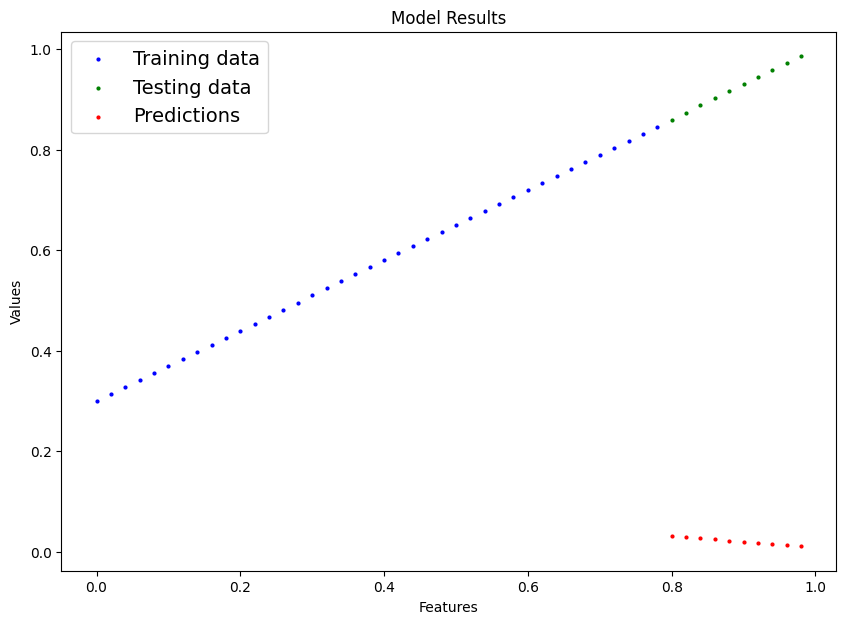

In [303]:
plot_predictions(X_train,y_train,X_test,y_test,y_preds)

Train model:

1.Loss function

2.Optimizer

In [304]:
model_0.parameters()

<generator object Module.parameters at 0x0000018E4138B4C0>

In [305]:
list(model_0.parameters())

[Parameter containing:
 tensor([-0.1115], requires_grad=True),
 Parameter containing:
 tensor([0.1204], requires_grad=True)]

In [306]:
model_0.state_dict()

OrderedDict([('weight', tensor([-0.1115])), ('bias', tensor([0.1204]))])

In [307]:
#MAE_loss = torch.mean(torch.abs(y_preds-y_test)) (One version to use)
#Setup for a loss function
loss_fn = nn.L1Loss() #Preferred version
#Setup for an optimizer function
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) #Stochastic gradient descent

Building a training loop in PyTorch

In [308]:
torch.manual_seed(123)
epochs = 10
#Loop throught the data
for epoch in range(epochs):
    #Set the model to training mode
    model_0.train() #Train mode in PyTorch sets all parameters that require gradients to require gradients
    #Forward Pass
    y_preds = model_0(X_train)
    #Calculate loss (MAE)
    loss = loss_fn(y_preds,y_train)
    #Optimizer zero grad
    optimizer.zero_grad()
    #Perform backpropagation on the loss w.r.t parameters of the model
    loss.backward()
    #Step the optimizer (perform gradient descent)
    optimizer.step()
    
    #Testing
    model_0.eval() #Turns off gradient tracking

#Print out model state dict
print(model_0.state_dict())

OrderedDict({'weight': tensor([-0.0725]), 'bias': tensor([0.2204])})


In [309]:
model_0.state_dict()

OrderedDict([('weight', tensor([-0.0725])), ('bias', tensor([0.2204]))])

In [310]:
torch.manual_seed(123)
epochs = 10
#Loop throught the data
for epoch in range(epochs):
    #Set the model to training mode
    model_0.train() #Train mode in PyTorch sets all parameters that require gradients to require gradients
    #Forward Pass
    y_preds = model_0(X_train)
    #Calculate loss (MAE)
    loss = loss_fn(y_preds,y_train)
    #Optimizer zero grad
    optimizer.zero_grad()
    #Perform backpropagation on the loss w.r.t parameters of the model
    loss.backward()
    #Step the optimizer (perform gradient descent)
    optimizer.step()
    
    #Testing
    model_0.eval() #Turns off gradient tracking
    
#Print out model state dict
print(model_0.state_dict())

OrderedDict({'weight': tensor([-0.0335]), 'bias': tensor([0.3194])})


In [311]:
model_0.state_dict()

OrderedDict([('weight', tensor([-0.0335])), ('bias', tensor([0.3194]))])

In [312]:
torch.manual_seed(123)
epochs = 10
#Loop throught the data
for epoch in range(epochs):
    #Set the model to training mode
    model_0.train() #Train mode in PyTorch sets all parameters that require gradients to require gradients
    #Forward Pass
    y_preds = model_0(X_train)
    #Calculate loss (MAE)
    loss = loss_fn(y_preds,y_train)
    #Optimizer zero grad
    optimizer.zero_grad()
    #Perform backpropagation on the loss w.r.t parameters of the model
    loss.backward()
    #Step the optimizer (perform gradient descent)
    optimizer.step()
    
    #Testing
    model_0.eval() #Turns off gradient tracking
    
#Print out model state dict
print(model_0.state_dict())

OrderedDict({'weight': tensor([0.0047]), 'bias': tensor([0.3974])})


In [313]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.0047])), ('bias', tensor([0.3974]))])

In [314]:
torch.manual_seed(123)
epochs = 1000
#Loop throught the data
for epoch in range(epochs):
    #Set the model to training mode
    model_0.train() #Train mode in PyTorch sets all parameters that require gradients to require gradients
    #Forward Pass
    y_preds = model_0(X_train)
    #Calculate loss (MAE)
    loss = loss_fn(y_preds,y_train)
    #Optimizer zero grad
    optimizer.zero_grad()
    #Perform backpropagation on the loss w.r.t parameters of the model
    loss.backward()
    #Step the optimizer (perform gradient descent)
    optimizer.step()
    
    #Testing
    model_0.eval() #Turns off gradient tracking
    
#Print out model state dict
print(model_0.state_dict())

OrderedDict({'weight': tensor([0.6964]), 'bias': tensor([0.3064])})


In [315]:
torch.manual_seed(123)
epochs = 100000
#Loop throught the data
for epoch in range(epochs):
    #Set the model to training mode
    model_0.train() #Train mode in PyTorch sets all parameters that require gradients to require gradients
    #Forward Pass
    y_preds = model_0(X_train)
    #Calculate loss (MAE)
    loss = loss_fn(y_train,y_preds)
    #Optimizer zero grad
    optimizer.zero_grad()
    #Perform backpropagation on the loss w.r.t parameters of the model
    loss.backward()
    #Step the optimizer (perform gradient descent)
    optimizer.step()
    
    #Testing
    model_0.eval() #Turns off gradient tracking
    
#Print out model state dict
print(model_0.state_dict())

OrderedDict({'weight': tensor([0.6964]), 'bias': tensor([0.3064])})


In [316]:
model_0.state_dict() #Hence we can be almost 100% sure that this is the best we can get

OrderedDict([('weight', tensor([0.6964])), ('bias', tensor([0.3064]))])

In [317]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

In [318]:
X_test.shape

torch.Size([10, 1])

In [319]:
y_preds.shape

torch.Size([40, 1])

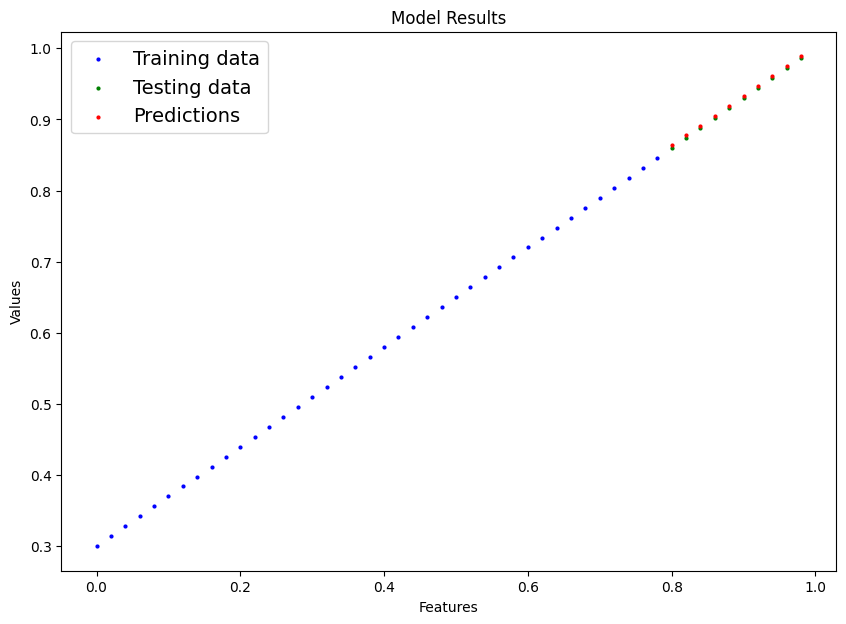

In [320]:
plot_predictions(X_train,y_train,X_test,y_test,y_preds_new)

In [321]:
#Testing loop
torch.manual_seed(123)
epochs = 100

#Tracking experiments
epoch_count = []
loss_values = []
test_loss_values = []

#Loop throught the data
for epoch in range(epochs):
    #Set the model to training mode
    model_0.train() #Train mode in PyTorch sets all parameters that require gradients to require gradients
    #Forward Pass
    y_preds = model_0(X_train)
    #Calculate loss (MAE)
    loss = loss_fn(y_train,y_preds)
    #Optimizer zero grad
    optimizer.zero_grad()
    #Perform backpropagation on the loss w.r.t parameters of the model
    loss.backward()
    #Step the optimizer (perform gradient descent)
    optimizer.step()
    
    #Testing
    model_0.eval() #Turns off gradient tracking
    with torch.inference_mode(): #turns off gradient tracking
        #Forward pass
        test_pred = model_0(X_test)
        #calculate the loss
        test_loss = loss_fn(test_pred,y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}") 
           
#Print out model state dict
print(model_0.state_dict())

Epoch: 0 | Loss: 0.0049704695120453835 | Test Loss: 0.010288244113326073
Epoch: 10 | Loss: 0.0049704695120453835 | Test Loss: 0.010288244113326073
Epoch: 20 | Loss: 0.0049704695120453835 | Test Loss: 0.010288244113326073
Epoch: 30 | Loss: 0.0049704695120453835 | Test Loss: 0.010288244113326073
Epoch: 40 | Loss: 0.0049704695120453835 | Test Loss: 0.010288244113326073
Epoch: 50 | Loss: 0.0049704695120453835 | Test Loss: 0.010288244113326073
Epoch: 60 | Loss: 0.0049704695120453835 | Test Loss: 0.010288244113326073
Epoch: 70 | Loss: 0.0049704695120453835 | Test Loss: 0.010288244113326073
Epoch: 80 | Loss: 0.0049704695120453835 | Test Loss: 0.010288244113326073
Epoch: 90 | Loss: 0.0049704695120453835 | Test Loss: 0.010288244113326073
OrderedDict({'weight': tensor([0.6964]), 'bias': tensor([0.3064])})


Saving & Loading the model

In [323]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6964])), ('bias', tensor([0.3064]))])

In [325]:
#Saving our pytorch model
from pathlib import Path

#Create models directory
Model_path = Path("models")
Model_path.mkdir(parents=True, exist_ok=True)

#Create model save path
Model_name = "LinearRegressionModel_Model_0.pth"
Model_save_path = Model_path / Model_name

#Save the model state dict (suggested method rather than saving whole model)
print(f"Saving the model to -> {Model_save_path}")
torch.save(model_0.state_dict(),Model_save_path)

Saving the model to -> models\LinearRegressionModel_Model_0.pth


In [328]:
#Loading a pytorch model
#To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()
#Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load("E:\\PyTorch\\models\\LinearRegressionModel_Model_0.pth"))

C:\Users\lenovo\AppData\Local\Temp\ipykernel_356\3073565233.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load("E:\\PyTorch\\model

<All keys matched successfully>

In [329]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6964])), ('bias', tensor([0.3064]))])

In [330]:
#Make some predictions with loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8635],
        [0.8774],
        [0.8914],
        [0.9053],
        [0.9192],
        [0.9331],
        [0.9471],
        [0.9610],
        [0.9749],
        [0.9889]])

In [331]:
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])